# Example of top-hat jet run

__General instructions__: 
1. Set the working directory, where model output will be saved.  
__Important__: _do not use_ the same folder for multiple runs. H5 library will try to override the file and fail, if the file is loaded somewhere. 
2. Set jet properties (initial Energy, lorentz factor, opening engle, etc. of he jet)
3. Set simulation parameters and settings as a dictionary
4. Run the simulation
5. Analyze the result

---

In [4]:
import copy, os, gc, h5py, numpy as np, matplotlib.pyplot as plt
import PyBlastAfterglowMag as pba
from PyBlastAfterglowMag.wrappers import run_grb
from PyBlastAfterglowMag.utils import cgs
from IPython.display import clear_output

## Setting up a simulation for top-hat jet 

A top-hat jet has only one angular layer -- one blastwave.   
- __Structure__: It is characterized by its initial energy `Eiso_c`, Lorentz factor `Gamma0c` and opening angle `theta_w` (3 parameters)   
- __Environemnt__: Assume constant density ISM `n_ism` (1 parameter)  
- __Observer__: The observer is located at a certain distance `d_l` (redshift `z`), and the jet axis has a certain angle with respect to the line of sight `theta_obs` (3 parameters)  
- __Microphysics__: Shock microphysics within one shock requires 3 parameters (simplest form) for fractions of internal energy in accelerated particles `eps_e_fs` and magnetic fields `eps_b_fs` and power-law slope of the electron distribution `p_fs` (3 parameters)  

Thus, a tophat jet with forward shock (FS) only needs 10 free parameters:
- `[ Eiso_c, Gamma0c, theta_w, n_ism, theta_obs, eps_e_fs, eps_b_fs, p_fs, d_l, z ]`   
(however, `d_l` and `z` are connected and the only need is theoretically free)

In [5]:
# Define jet structure (analytic; tophat) -- 3 free parameters 
struct = dict(
    struct="tophat", # type of the structure tophat or gaussian
    Eiso_c=1.e53,    # isotropic equivalent energy of the burst 
    Gamma0c=400.,    # lorentz factor of the core of the jet 
    M0c=-1.,         # mass of the ejecta (if -1 -- iferr from Eiso_c and Gamma0c)
    theta_c=0.1,     # half-opening angle of the core of the jet
    theta_w=0.1      # half-opening angle of the winds of the jet
)

# set model parameters
P = dict(
        # main model parameters; Uniform ISM -- 2 free parameters
        main=dict(
            d_l=3.09e26, # luminocity distance to the source [cm]
            z = 0.028,   # redshift of the source (used in Doppler shifring and EBL table)
            n_ism=1.,    # ISM density [cm^-3] (assuming uniform)
            theta_obs=0, # observer angle [rad] (from pol to jet axis)  
            rtol=5e-7,   # relative tolerance for adaptive quadrature that compute observed emission
            lc_freqs='array logspace 1e8 1e29 96', # frequencies for light curve calculation
            lc_times='array logspace 3e3 1e10 128', # times for light curve calculation
            tb0=3e3,tb1=1e12,ntb=1000, # burster frame time grid boundary, resolution, for the simulation
        ),
        # ejecta parameters; FS only -- 3 free parameters 
        grb=dict(
            structure=struct, # structure of the ejecta
            eps_e_fs=0.1,     # microphysics - FS - frac. energy in electrons
            eps_b_fs=0.001,   # microphysics - FS - frac. energy in magnetic fields
            p_fs=2.2,         # microphysics - FS - slope of the injection electron spectrum
            do_lc='yes',      # task - compute light curves
            save_spec='yes' # save comoving spectra 
            # method_synchrotron_fs = 'WSPN99',
            # method_ne_fs = 'usenprime',
            # method_ele_fs = 'analytic',
            # method_comp_mode = 'observFlux'
        )
)

### Run the code with required parameters

In [6]:
# code needs a working directory where to save initial data & final results
working_dir = os.getcwd() + '/tmp/' # default working directory

# run the code and get the instance of a python interfact to the code intput/output 
pba_run = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P,                     # all parameters 
    run=False,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

### Run also afterglowpy for comparison
See details in https://github.com/geoffryan/afterglowpy 

In [7]:
import afterglowpy as grb 
class RunAfterglowpy:
    def __init__(self, P:dict):
        # afterglopy also need a dict as a parameter set; but a different one
        struct = P["grb"]["structure"]
        pp = P["grb"]
        Z = {
            'jetType':     grb.jet.TopHat if struct["struct"] == "tophat" else grb.jet.Gaussian,     # Top-Hat jet
            'specType':    0,                  # Basic Synchrotron Spectrum
            'counterjet':  1,
            'spread':      7, #if pba.GRB.opts["method_spread"] != "None" else -1,
            'n0':          P["main"]["n_ism"],    # circumburst density in cm^{-3}
            'thetaObs':    P["main"]["theta_obs"],   # Viewing angle in radians
            'd_L':         P["main"]["d_l"], # Luminosity distance in cm
            'z':           P["main"]["z"],   # redshift
            'E0':          struct["Eiso_c"], # Isotropic-equivalent energy in erg
            'g0':          struct["Gamma0c"],
            'thetaCore':   struct["theta_c"],    # Half-opening angle in radians
            'thetaWing':   struct["theta_w"],
            'p':           pp["p_fs"],    # electron energy distribution index
            'epsilon_e':   pp["eps_e_fs"],    # epsilon_e
            'epsilon_B':   pp["eps_b_fs"],   # epsilon_B
            'xi_N':        1.0,    # Fraction of electrons accelerated
        }
        # run spectrum
        times_set = P["main"]["lc_times"]
        times = np.logspace(np.log10(float(times_set.split()[-3])),
                            np.log10(float(times_set.split()[-2])),
                            int(times_set.split()[-1]))
        freq_set = P["main"]["lc_freqs"]
        freqs = np.logspace(np.log10(float(freq_set.split()[-3])),
                            np.log10(float(freq_set.split()[-2])),
                            int(freq_set.split()[-1]))
        # all_times = np.concatenate([times for _ in range(len(freqs))])
        # all_freqs = np.concatenate([times for _ in range(len(freqs))])
        all_times, all_freqs = [], []
        for it, t in enumerate(times):
            for ifreq, freq in enumerate(freqs):
                all_times.append(t)
                all_freqs.append(freq)
        all_times = np.array(all_times)
        all_freqs = np.array(all_freqs)
        # takes equal size arrays to compute lightcurves
        Fnu = grb.fluxDensity(all_times, all_freqs, **Z)
        Fnu = np.reshape(Fnu, newshape=(len(times),len(freqs)))
        self.spec = Fnu
        self.freqs = freqs
        self.times = times

    def get_lc(self, freq:float):
        idx = (np.abs(self.freqs - freq)).argmin()
        return self.spec[:,idx]
    
    def get_spec(self, time:float):
        idx = (np.abs(self.times - time)).argmin()
        return self.spec[idx,:]
afgpy = RunAfterglowpy(P=P)

### Run also jetsimpy for comparison
See details in https://github.com/haowang-astro/jetsimpy


In [8]:
import jetsimpy
class RunJetsimpy:
    def __init__(self, P:dict):
        struct = P["grb"]["structure"]
        # jetsimpy also need a dict as a parameter set; but a different one
        pp = dict(
            Eiso = struct["Eiso_c"],        # (Jet) Isotropic equivalent energy
            lf = struct["Gamma0c"],           # (Jet) Lorentz factor
            # theta_c = struct["theta_c"],      # (Jet) half opening angle
            n0 = P["main"]["n_ism"],             # (ISM) constant number density
            k = 0.0,            # (ISM) wind power index
            A = 0,              # (ISM) wind amplitude
            eps_e = P["grb"]["eps_e_fs"],        # (Radiation) epsilon_e
            eps_b = P["grb"]["eps_b_fs"],       # (Radiation) epsilon_b
            p = P["grb"]["p_fs"],           # (Radiation) electron power index
            theta_v = P["main"]["theta_obs"],      # (Radiation) viewing angle
            d = P["main"]["d_l"]/cgs.pc/1e6,         # (radiation) distance (Mpc)
            z = P["main"]["z"],            # (radiation) redshift
            xi_N = 1.0,       # (radiation customized) total fraction of accelerated electrons
            b = 0,              # (radiation) magnetic field anisotropy
        )
        # this code does not take structure parameters, but an actual structure itself
        if struct["struct"] == "tophat":
            theta = np.linspace(0, np.pi, 1000)
            Eiso = np.full_like(theta, pp["Eiso"]) # P["Eiso"] * np.exp(- 0.5 * (theta / P["theta_c"]) ** 2)
            lf = np.full_like(theta, pp["lf"]) #(P["lf"] - 1) * np.exp(- 0.5 * (theta / P["theta_c"]) ** 2) + 1
            lf[theta > struct["theta_w"]] = 0.
            Eiso[theta > struct["theta_w"]] = 0.
        elif struct["struct"] == "gaussian":
            theta = np.linspace(0, np.pi, 1000)
            Eiso = pp["Eiso"] * np.exp(- 0.5 * (theta / struct["theta_c"]) ** 2)
            lf = (pp["lf"] - 1) * np.exp(- 0.5 * (theta / struct["theta_c"]) ** 2) + 1
            # Eiso[theta > struct["theta_w"]] = 0.
        else:
            raise KeyError("structure is not recognized")
            
        # do light curve
        if True:
            jet1 = jetsimpy.Afterglow(
                theta,           # array of theta
                Eiso,            # array of isotropic equivalent energy
                lf,              # array of initial lorentz factor
                # 0.,
                pp["A"],          # scale of wind density
                pp["n0"],         # constant number density
                tmin=P["main"]["tb0"],
                tmax=P["main"]["tb1"],
                spread=True,#pba.GRB.opts["method_spread"] != "None",    # (default = True) with/without spreading effect
                coast=True,      # (default = True) with/without coasting. If this is "False", the initial lorentz factor data will be omitted.
            )
            times_set = P["main"]["lc_times"]
            times = np.logspace(np.log10(float(times_set.split()[-3])),
                            np.log10(float(times_set.split()[-2])),
                            int(times_set.split()[-1]))
            freq_set = P["main"]["lc_freqs"]
            freqs = np.logspace(np.log10(float(freq_set.split()[-3])),
                            np.log10(float(freq_set.split()[-2])),
                            int(freq_set.split()[-1]))
            Fnu = []
            for ifreq, freq in enumerate(freqs):
                lc = jet1.FluxDensity(
                    times,           # [second] observing time span
                    freq,                # [Hz]     observing frequency
                    copy.deepcopy(pp),                 # parameter dictionary for radiation
                    rtol=1e-2,         # (default=1e-2) integration error tolerance
                    model="sync",      # default radiation model
                )
                Fnu.append(lc)
            spec = np.reshape(np.array(Fnu),newshape=(len(freqs),len(times))).T
            self.times = times
            self.freqs = freqs
            self.spec = spec
    
    def get_lc(self, freq:float):
        idx = (np.abs(self.freqs - freq)).argmin()
        return self.spec[:,idx]
    
    def get_spec(self, time:float):
        idx = (np.abs(self.times - time)).argmin()
        return self.spec[idx,:]
jetpy = RunJetsimpy(P=P)

##  Analyze results of the run
### Plot electron spectrum 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


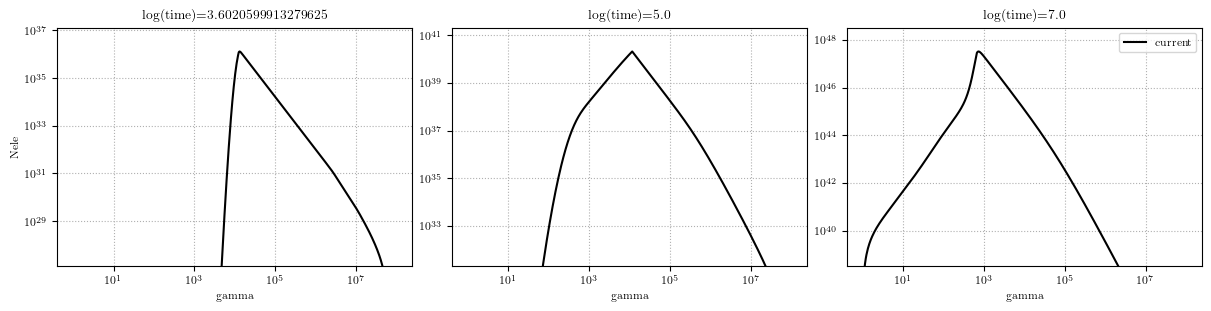

In [10]:
def plot_ele_spectra(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None,times:tuple):
    # get light curves
    # times = ejecta.get_lc_times()
    gams = ejecta.get_gams()
    fig, axes = plt.subplots(nrows=1,ncols=len(times),figsize=(12,3),layout='constrained')
    for i, time in enumerate(times):
        spec = ejecta.get_lc(time=time,xkey="gams",key_time="times_gams",key="n_ele_fs",ishell=0,ilayer=0,spec=True)
        # spec = freqs*spec*1e-3*1e-23
        axes[i].plot(gams, spec,color='black', label='current')
        if not ejecta_def is None:
            spec = ejecta_def.get_lc(time=time,xkey="gams",key_time="times_gams",key="n_ele_fs",ishell=0,ilayer=0,spec=True)
            # spec = freqs*spec*1e-3*1e-23
            axes[i].plot(gams, spec,color='gray',ls=':', label='default')
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-9*np.max(spec), 10*np.max(spec))
        axes[i].set_title(f"log(time)={np.log10(time)}")
        axes[i].set_xlabel("gamma")
        axes[i].grid(ls=':')
        axes[-1].legend()
    axes[0].set_ylabel("Nele")
    plt.show()
plot_ele_spectra(ejecta=pba_run.GRB,ejecta_def=None,times=(4e3, 1e5, 1e7))

### Plot light curves

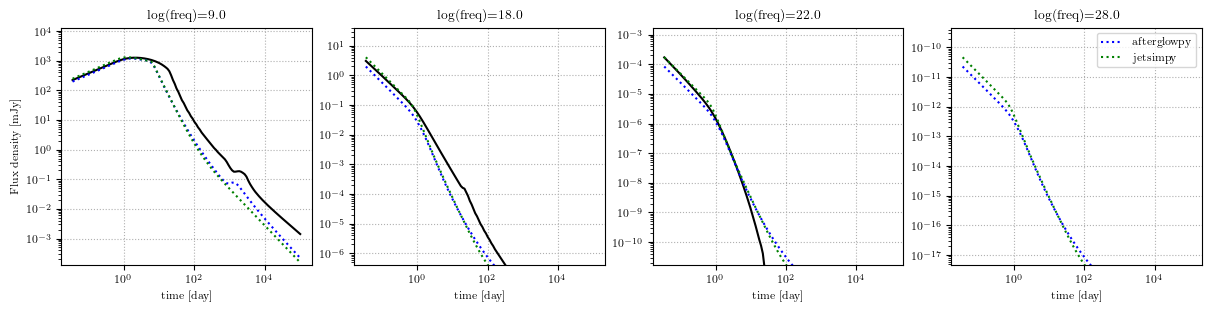

In [11]:
# plot light curves
def plot_lcs(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None, freqs:tuple, 
             afgpy:RunAfterglowpy | None, jetpy:RunJetsimpy | None):
    # get light curves
    times = ejecta.get_lc_times()
    # freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(freqs),figsize=(12,3),layout='constrained')
    for i, freq in enumerate(freqs):
        lc = ejecta.get_lc(freq=freq)
        axes[i].plot(times/cgs.day, lc,color='black')
        if not ejecta_def is None:
            lc = ejecta_def.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='gray',ls=':', label='Default')
        if not afgpy is None:
            lc = afgpy.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='blue',ls=':', label='afterglowpy')
        if not jetpy is None:
            lc = jetpy.get_lc(freq=freq)
            axes[i].plot(times/cgs.day, lc,color='green',ls=':', label='jetsimpy')
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-7*np.max(lc), 10*np.max(lc))
        axes[i].set_title(f"log(freq)={np.log10(freq)}")
        axes[i].set_xlabel("time [day]")
        axes[i].grid(ls=':')
    axes[0].set_ylabel("Flux density [mJy]")
    axes[-1].legend()
    plt.show()
plot_lcs(ejecta=pba_run.GRB, ejecta_def=None, freqs=(1e9, 1e18, 1e22, 1e28), afgpy=afgpy, jetpy=jetpy)

### Plot spectra

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


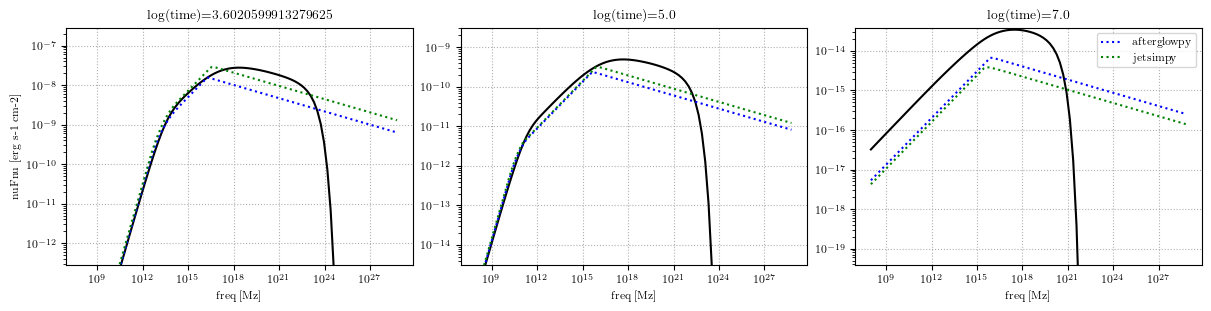

In [12]:
def plot_spectra(ejecta:pba.interface.Ejecta,ejecta_def:pba.interface.Ejecta | None,times:tuple,
                 afgpy:RunAfterglowpy | None, jetpy:RunJetsimpy | None):
    # get light curves
    # times = ejecta.get_lc_times()
    freqs = ejecta.get_lc_freqs()
    fig, axes = plt.subplots(nrows=1,ncols=len(times),figsize=(12,3),layout='constrained')
    for i, time in enumerate(times):
        spec = ejecta.get_lc(time=time)
        spec = freqs*spec*1e-3*1e-23
        axes[i].plot(freqs, spec,color='black')
        if not ejecta_def is None:
            spec = ejecta_def.get_lc(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='gray',ls=':', label='Default')
        if not afgpy is None:
            spec = afgpy.get_spec(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='blue',ls=':', label='afterglowpy')
        if not jetpy is None:
            spec = jetpy.get_spec(time=time)
            spec = freqs*spec*1e-3*1e-23
            axes[i].plot(freqs, spec,color='green',ls=':', label='jetsimpy')
        axes[i].set_xscale('log')
        axes[i].set_yscale('log')
        axes[i].set_ylim(1e-5*np.max(spec), 10*np.max(spec))
        axes[i].set_title(f"log(time)={np.log10(time)}")
        axes[i].set_xlabel("freq [Mz]")
        axes[i].grid(ls=':')
        axes[-1].legend()
    axes[0].set_ylabel("nuFnu [erg s-1 cm-2]")
    plt.show()
plot_spectra(ejecta=pba_run.GRB,ejecta_def=None,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

##  VHE lightcurves and spectra
Let's consider including synchrotron self-compton (SSC) and pp-process. 

Run is more computationally expensive. Takes about ~3 minutes.

In [14]:
P_ssc=copy.deepcopy(P)
P_ssc["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_ssc["grb"]["method_pp_fs"] = "numeric" # from none -> numeric
working_dir = os.getcwd() + '/tmp_ssc/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_ssc = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_ssc,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="err",
    process_skymaps=False 
)
clear_output(wait=False)

### Plot light curves and spectra and compare with previous run

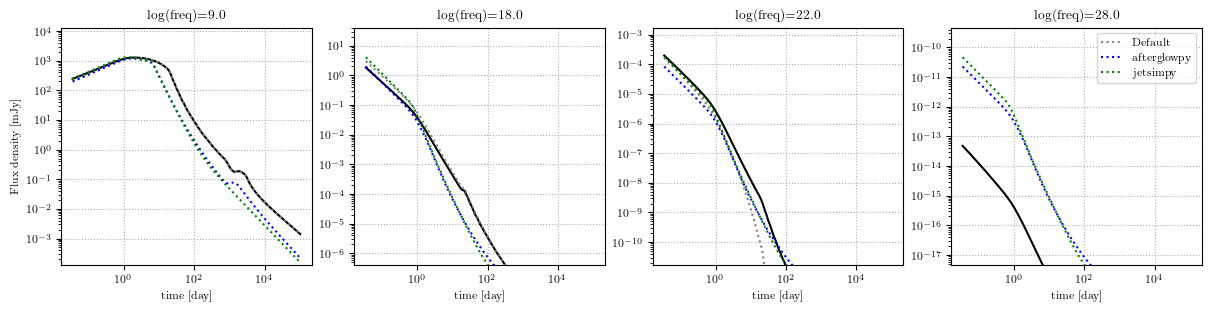

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


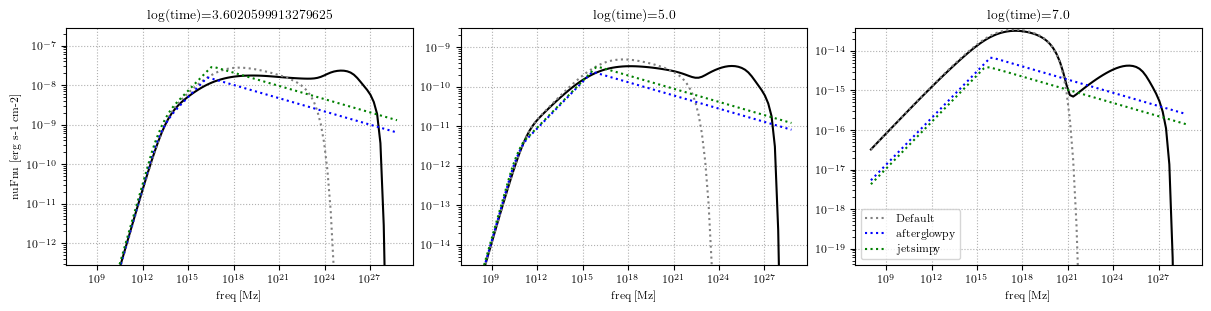

In [16]:
#plot_ele_spectra(ejecta=pba_run_ssc.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7))
plot_lcs(ejecta=pba_run_ssc.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28),afgpy=afgpy,jetpy=jetpy)
plot_spectra(ejecta=pba_run_ssc.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

##  Add Reverse Shock
Reverse shock changes blastwaves dynamis and produces its own emission component (mostly seen at early times and at low frequencies) 

As it is a separate shocks with distinct microphsyics, free parameters need to be defined, same as for foward shock (3 more free parameters)

In [18]:
P_fsrs=copy.deepcopy(P)

# include VHE for forward shock
P_fsrs["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_fsrs["grb"]["method_pp_fs"] = "numeric" # from none -> numeric

# include RS into blastwave dynamics calculation
P_fsrs["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs["grb"]["bw_type"] = "fsrs" # from none -> numeric

# set shock parameters
P_fsrs["grb"]["eps_e_rs"] = 0.1 
P_fsrs["grb"]["eps_b_rs"] = 0.01
P_fsrs["grb"]["p_rs"] = 2.2

working_dir = os.getcwd() + '/tmp_fsrs/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="err",
    process_skymaps=False 
)
clear_output(wait=False)
# 2 min

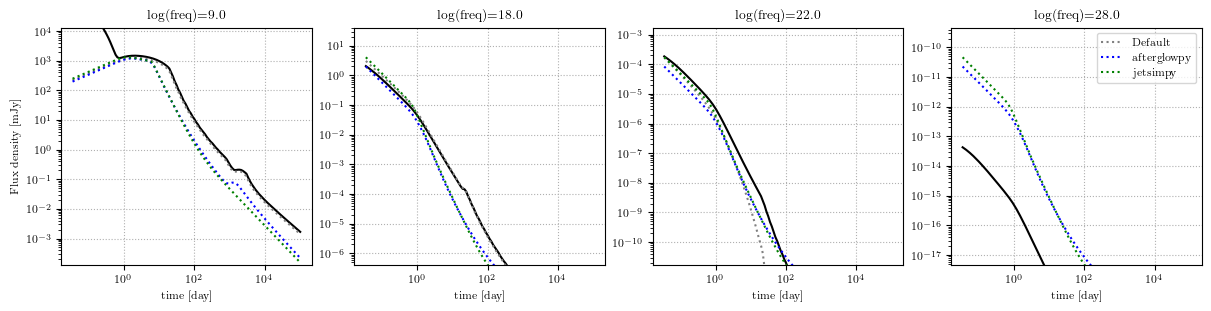

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


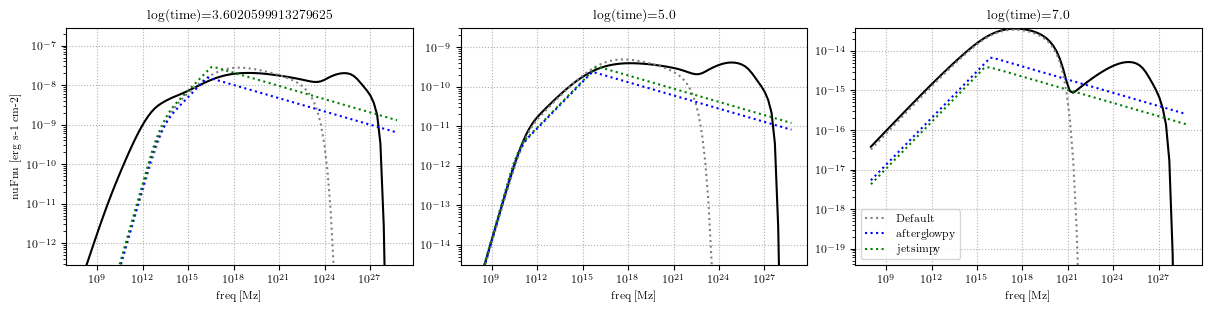

In [19]:
plot_lcs(ejecta=pba_run_fsrs.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28),afgpy=afgpy,jetpy=jetpy)
plot_spectra(ejecta=pba_run_fsrs.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

## SSA for FS and RS

Here we also add synchrotron self-absorptiion that changes the very low energy part of the spectrum

In [25]:
P_fsrs=copy.deepcopy(P)

# Add high energy part (SSC and PP)
P_fsrs["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_fsrs["grb"]["method_pp_fs"] = "numeric" # from none -> numeric

# Add SSA (low energy part absorption)
P_fsrs["grb"]["use_ssa_fs"] = "yes" # from none -> numeric
P_fsrs["grb"]["use_ssa_rs"] = "yes" # from none -> numeric

# Include Reverse shock 
P_fsrs["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs["grb"]["bw_type"] = "fsrs" # from none -> numeric

# Microphsyics for reverse shock
P_fsrs["grb"]["eps_e_rs"] = 0.1
P_fsrs["grb"]["eps_b_rs"] = 0.01
P_fsrs["grb"]["p_rs"] = 2.2

working_dir = os.getcwd() + '/tmp_fsrs_ssa_ssc_pp/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs_ssa_ssc_pp = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs,                     # all parameters 
    run=True,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False 
)
clear_output(wait=False)

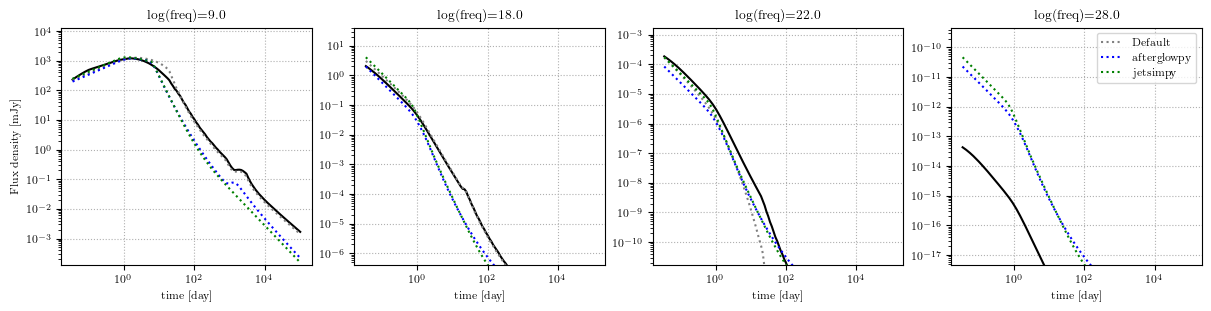

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


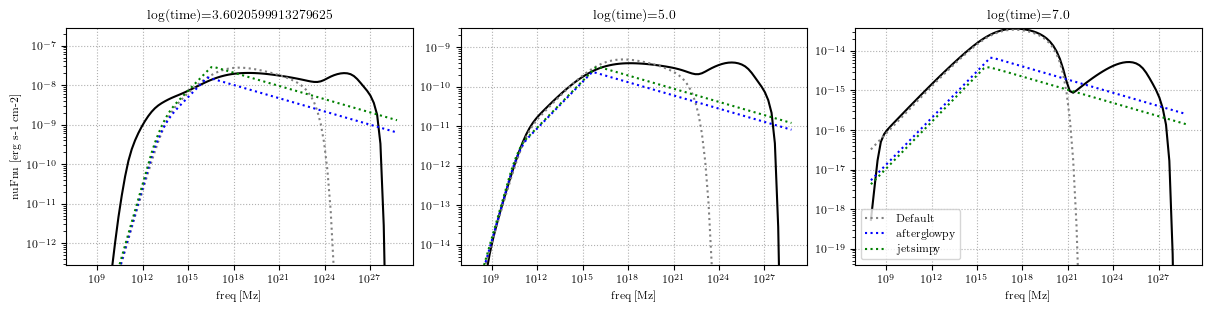

In [27]:
plot_lcs(ejecta=pba_run_fsrs_ssa_ssc_pp.GRB,ejecta_def=pba_run.GRB,freqs=(1e9, 1e18, 1e22, 1e28),afgpy=afgpy,jetpy=jetpy)
plot_spectra(ejecta=pba_run_fsrs_ssa_ssc_pp.GRB,ejecta_def=pba_run.GRB,times=(4e3, 1e5, 1e7),afgpy=afgpy,jetpy=jetpy)

## Sky map analysis

Sky map is an image of a GRB afterglow on a sky plane. In other words, it is an intensity distribution on a plane perpendicular to the line of sight. Numerically, it is importnat to resolve the image, -- have enough emitting regions. This is achieved iteratively. However, this makes calculations slower. 

One needs to specify times and frequencies at which sky maps are computed. 

After sky maps are computed and saved in separate hdf5 files, a separate python function _post-processeses them_: concatenates them, cleans the data, and extracts usefull quantities (image size, flux centroid positon...). 

To do this, pass `skymap_conf` to the `grb` part of the parameter dict, and set `process_skymaps` to true.  
Note: by default raw skymaps will not be removed and can be processed again with different skymap_conf, -- so no need to re-run the full simulation.

In [20]:
P_fsrs_ssc_skymap=copy.deepcopy(P)
P_fsrs_ssc_skymap["grb"]["method_ssc_fs"] = "numeric" # from none -> numeric
P_fsrs_ssc_skymap["grb"]["method_pp_fs"] = "numeric" # from none -> numeric

P_fsrs_ssc_skymap["grb"]["do_rs"] = "yes" # from none -> numeric
P_fsrs_ssc_skymap["grb"]["bw_type"] = "fsrs" # from none -> numeric

P_fsrs_ssc_skymap["grb"]["eps_e_rs"] = 0.1
P_fsrs_ssc_skymap["grb"]["eps_b_rs"] = 0.01
P_fsrs_ssc_skymap["grb"]["p_rs"] = 2.2

# specify sky map properties 
P_fsrs_ssc_skymap["grb"]["do_skymap"] = "yes"
P_fsrs_ssc_skymap["grb"]["nsublayers"] = 11 # parameter for iterative algorithm to keep resizing the jet layer to increase sky map resolution
P_fsrs_ssc_skymap["main"]["skymap_freqs"] = "array 1e9 1e18" 
P_fsrs_ssc_skymap["main"]["skymap_freqs"] = "array logspace 8.e5 2e9 50"

# how to post-process sky maps 
skymap_conf=dict(nx=128, ny=64, extend_grid=2, fwhm_fac=0.5, lat_dist_method="integ",
                intp_filter=dict(type='gaussian', size=2, sigma=1.5, mode='reflect'),  # "gaussian"
                hist_filter=dict(type='gaussian', size=2, sigma=1.5, mode='reflect'))
P_fsrs_ssc_skymap["grb"]["skymap_conf"] = skymap_conf

working_dir = os.getcwd() + '/tmp_fsrs_ssc_skymap/' # new working directory for clarity

# run the code and get the instance of a python interfact to the code intput/output 
pba_run_fsrs_ssc_skymap = run_grb(
    working_dir=working_dir, # directory to save/load from simulation data
    P=P_fsrs_ssc_skymap,                     # all parameters 
    run=False,                # run code itself (if False, it will try to load results)
    path_to_cpp="/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/src/pba.out",
    loglevel="info",
    process_skymaps=False # ! concantenate raw .hdf5 sky maps into 1 clean file (& clean data)
)
clear_output(wait=False)

## Sky map plotting

Saving:\n/home/vsevolod/Work/GIT/GitHub/PyBlastAfterglowMag/notebooks/grb_afterglow/.png


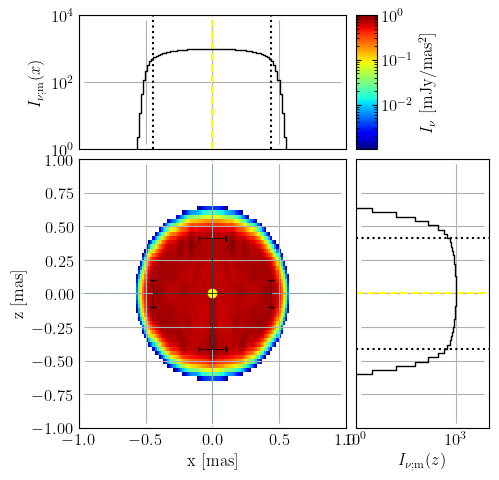

In [21]:
config = {
        "gridspec": {
            "width_ratios": (4, 2), "height_ratios": (2, 4),
            "left": 0.19, "right": 0.95, "bottom": 0.1, "top": 0.96, "wspace": 0.05, "hspace": 0.05
        },
        "figname": "out", "paperpath": os.getcwd()+'/', "figfpath": os.getcwd()+'/', "save_pdf": False, "save_figs": True,
        "show_figs": True,
        "grid": False,
        "figsize": (5.4, 4.8),
        "type":"hist",
        "cm": {"color": 'yellow', "marker": "o"},
        "ysize": {"capsize": 2, "color": "black", "lw": 0.5},
        "xsize": {"capsize": 2, "color": "black", "lw": 0.5},
        "pcolormesh": {"cmap": 'jet', "set_under": 'white', "set_over": None, "set_rasterized": True,
                       "norm": ("log", "0.001max", "1max"), "facecolor": None, "alpha": 1.0, "isnan": np.nan},
        "xlim": (-1., 1.0), "ylim": (-1.0, 1.0),
        "title": {"title": "time_fluxratio"},  # "time_fluxratio"
        "cbar_title": r'$I_{\nu}^{\rm w}/I_{\nu}^{\rm w/o}$',
        "xlabel": "x [mas]", "ylabel": "z [mas]",
        "histx_backgound_color": "white",
        "histy_backgound_color": "white",
        "plot_grids":True,
        "histx_lim":(1e0,1e4),
        "histy_lim":(1e0,1e4)
    }
time= 500.*cgs.day
freq= 1.e9
pba.skymap_plotting_tools.full_plot_skymap_with_hists(
    skymap=pba_run_fsrs_ssc_skymap.GRB.get_skymap(time=time, freq=freq), conf=config)

### Plot Sky map properties evolution

Plot evolution of key paraeters of sky maps

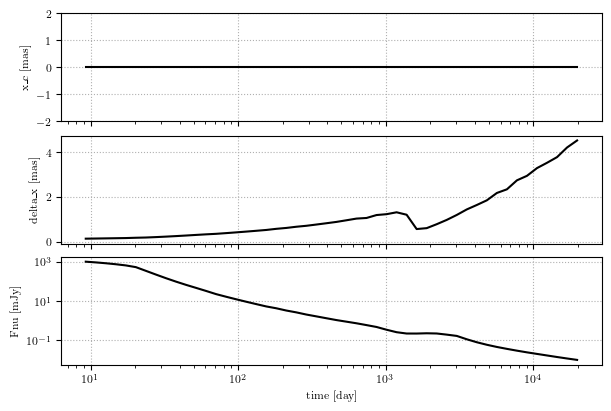

In [22]:
def plot_skymap_prop_evoluton(ejecta:pba.Ejecta, freq:float):
    times = ejecta.get_skymap_times() 
    skymaps = [ejecta.get_skymap(time=t, freq=freq) for t in times]
    xcs = [skymap.xc for skymap in skymaps]
    delta_x = [abs(skymap.x2-skymap.x1) for skymap in skymaps]
    fluxes = [skymap.flux for skymap in skymaps]

    fig,axes = plt.subplots(ncols=1,nrows=3,sharex='all',layout='constrained',figsize=(6,4))
    
    axes[0].plot(times/cgs.day, xcs, color='black', ls='-')
    axes[0].set_ylabel("x_c [mas]")
    axes[0].set_ylim(-2,2)
    
    axes[1].plot(times/cgs.day, delta_x, color='black', ls='-')
    axes[1].set_ylabel("delta_x [mas]")

    axes[2].plot(times/cgs.day, fluxes, color='black', ls='-')
    axes[2].set_ylabel("Fnu [mJy]")
    axes[2].set_yscale("log")

    for ax in axes:
        ax.set_xscale('log')
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [day]')
plot_skymap_prop_evoluton(ejecta=pba_run_fsrs_ssc_skymap.GRB,
                          freq=1e9)